In [1]:
import numpy as np
import pandas as pd
import torch
import pickle
import matplotlib.pyplot as plt
from lpne.models import DcsfaNmf

MODEL_FILE = "/hpc/home/mk423/Anxiety/FullDataWork/Models/Final_mt_Model_500_epochs.pt"
DATA_PATH = "/work/mk423/Anxiety/"
PROJECT_PATH = "/hpc/home/mk423/Anxiety/FullDataWork/Projections/"
FIGURE_PATH = "/hpc/home/mk423/Anxiety/FullDataWork/Figures/"
data_file = DATA_PATH + "EPM_test_dict_May_17.pkl"
proj_file = PROJECT_PATH + "EPM_Holdout_Projections_w_agg.csv"
mean_file = PROJECT_PATH + "EPM_Holdout_mean_scores_w_agg.csv"

model = torch.load(MODEL_FILE,map_location="cpu")
model.device="cpu"


old_feature_list = ["X_power_1_2","X_coh_1_2","X_gc_1_2"]
feature_weights = [10,1,1]



import os, sys
umc_data_tools_path = "/hpc/home/mk423/Anxiety/Universal-Mouse-Code/"
sys.path.append(umc_data_tools_path)
import umc_data_tools as umc_dt

def get_3_net_aucs(s,y,y_group=None):
    
    auc_mean_list = []
    auc_stderr_list =[]
    
    if y_group is None:
        y_group = np.ones(s.shape[0])
        
    for i in range(3):
        auc_dict = umc_dt.lpne_auc(y,y,y_group,s[:,i].reshape(-1,1),mannWhitneyU=True)
        mean = np.mean([auc_dict[key][0] for key in auc_dict.keys() if key != "auc_method"])
        stderr = np.std([auc_dict[key][0] for key in auc_dict.keys() if key != "auc_method"]) / np.sqrt(len(auc_dict.keys()))
        
        auc_mean_list.append(mean)
        auc_stderr_list.append(stderr)
        
    return auc_mean_list, auc_stderr_list

def get_3_net_auc_dict(s,y,y_group=None):
    auc_dict_list = []
    
    if y_group is None:
        y_group = np.ones(s.shape[0])
        
    for i in range(3):
        auc_dict = umc_dt.lpne_auc(y,y,y_group,s[:,i].reshape(-1,1),mannWhitneyU=True)
        auc_dict_list.append(auc_dict)
        
    return auc_dict_list

/opt/conda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/hpc/home/mk423/.local/lib/python3.7/site-packages/lpne/pipelines/__init__.py:14: UserWarning: Could not load lpne/pipelines/default_params.yaml!
  warnings.warn("Could not load lpne/pipelines/default_params.yaml!")


In [2]:
with open(data_file,"rb") as f:
    epm_test_dict = pickle.load(f)

X_test = np.hstack([epm_test_dict[feature]*weight for feature,weight in zip(old_feature_list,feature_weights)])
y_test = ~(epm_test_dict['y_ROI']%2).astype(bool)
y_in_task_mask_test= ~epm_test_dict['y_Homecage'].astype(bool)
y_mouse_test = epm_test_dict['y_mouse']
y_time_test = epm_test_dict['y_time']
test_nan_mask = (epm_test_dict['y_ROI'] > 0)
epm_y_expDate_test = epm_test_dict['y_expDate']

In [3]:
np.unique(epm_test_dict['y_vel'][y_in_task_mask_test==0])

array([-2147483648], dtype=int32)

In [4]:
epm_test_dict['y_ROI']

array([1, 1, 3, ..., 1, 1, 1], dtype=int32)

In [5]:
epm_test_auc = model.score(X_test,
                          y_in_task_mask_test.reshape(-1,1),
                          y_mouse_test,
                          return_dict=True)

epm_mean_test_auc = np.mean([epm_test_auc[key] for key in epm_test_auc.keys()])
epm_stderr_test_auc = np.std([epm_test_auc[key] for key in epm_test_auc.keys()]) / np.sqrt(len(epm_test_auc.keys()))

print("EPM test auc: {:.3f} +/- {:.3f}".format(epm_mean_test_auc,epm_stderr_test_auc))
print(epm_test_auc)

EPM test auc: 0.756 +/- 0.027
{'Mouse0641': [0.7422324510932107], 'Mouse39115': [0.891685935457927], 'Mouse39121': [0.906627367939106], 'Mouse39122': [0.7198150541108062], 'Mouse39132': [0.6635451110061408], 'Mouse39135': [0.871639430680021], 'Mouse6674': [0.6546029776674938], 'Mouse69061': [0.7085181384141715], 'Mouse69071': [0.7389144033573523], 'Mouse69075': [0.7610080628315996], 'Mouse8893': [0.6597929274098717]}


In [6]:
s_epm_test = model.project(X_test)
auc_epm_test = [epm_test_auc[mouse][0] for mouse in y_mouse_test]
auc_epm_test_3_net = get_3_net_auc_dict(s_epm_test,
                                        y_in_task_mask_test,
                                        y_mouse_test)

coeffs = np.abs(model.classifier[0].weight[0].detach().cpu().numpy())
agg_score = s_epm_test[:,:3] @ coeffs
proj_dict = {
    "agg score":agg_score,
    "net 1 scores":s_epm_test[:,0],
    "net 2 scores":s_epm_test[:,1],
    "net 3 scores":s_epm_test[:,2],
    "in-task":y_in_task_mask_test,
    "mouse":y_mouse_test,
    "time":y_time_test,
    "expDate":epm_y_expDate_test,
    "auc (Homecage vs. Task)":auc_epm_test,
    "net 1 auc (Homecage vs. Task)":[auc_epm_test_3_net[0][mouse][0] for mouse in y_mouse_test],
    "net 2 auc (Homecage vs. Task)":[auc_epm_test_3_net[1][mouse][0] for mouse in y_mouse_test],
    "net 3 auc (Homecage vs. Task)":[auc_epm_test_3_net[2][mouse][0] for mouse in y_mouse_test],
    "roi":epm_test_dict["y_ROI"],
    "velocity":epm_test_dict["y_vel"],
    
}

df_proj = pd.DataFrame.from_dict(proj_dict)
#df_proj.to_csv(proj_file)
df_proj.head()

,agg score,net 1 scores,net 2 scores,net 3 scores,in-task,mouse,time,expDate,auc (Homecage vs. Task),net 1 auc (Homecage vs. Task),net 2 auc (Homecage vs. Task),net 3 auc (Homecage vs. Task),roi,velocity
0,2.412547,0.081440,0.092658,0.096652,False,Mouse0641,1,110717,0.742232,0.71893,0.735664,0.442271,1,-2147483648
1,1.725192,0.062944,0.062938,0.081924,False,Mouse0641,2,110717,0.742232,0.71893,0.735664,0.442271,1,-2147483648
2,2.546790,0.083994,0.098514,0.112678,False,Mouse0641,4,110717,0.742232,0.71893,0.735664,0.442271,3,-2147483648
3,4.039915,0.129436,0.163424,0.065320,False,Mouse0641,12,110717,0.742232,0.71893,0.735664,0.442271,3,-2147483648
4,2.756711,0.072507,0.120995,0.040223,False,Mouse0641,13,110717,0.742232,0.71893,0.735664,0.442271,3,-2147483648


In [7]:
mouse_roi_comp_net_OA_dict = {}
mouse_roi_1_net_OA_dict = {}
mouse_roi_2_net_OA_dict = {}
mouse_roi_3_net_OA_dict = {}

mouse_roi_comp_net_CA_dict = {}
mouse_roi_1_net_CA_dict = {}
mouse_roi_2_net_CA_dict = {}
mouse_roi_3_net_CA_dict = {}

for mouse in np.unique(df_proj["mouse"]):
    task_mouse_mask = np.logical_and(df_proj["in-task"]==1,df_proj["mouse"]==mouse)
    
    comp_score_mean_OA = np.mean(df_proj[np.logical_and(df_proj["roi"]%2==1,task_mouse_mask)]["agg score"])
    net_1_scores_mean_OA = np.mean(df_proj[np.logical_and(df_proj["roi"]%2==1,task_mouse_mask)]["net 1 scores"])
    net_2_scores_mean_OA = np.mean(df_proj[np.logical_and(df_proj["roi"]%2==1,task_mouse_mask)]["net 2 scores"])
    net_3_scores_mean_OA = np.mean(df_proj[np.logical_and(df_proj["roi"]%2==1,task_mouse_mask)]["net 3 scores"])
    
    mouse_roi_comp_net_OA_dict[mouse] = comp_score_mean_OA
    mouse_roi_1_net_OA_dict[mouse] = net_1_scores_mean_OA
    mouse_roi_2_net_OA_dict[mouse] = net_2_scores_mean_OA
    mouse_roi_3_net_OA_dict[mouse] = net_3_scores_mean_OA
    
    comp_score_mean_CA = np.mean(df_proj[np.logical_and(df_proj["roi"]%2==0,task_mouse_mask)]["agg score"])
    net_1_scores_mean_CA = np.mean(df_proj[np.logical_and(df_proj["roi"]%2==0,task_mouse_mask)]["net 1 scores"])
    net_2_scores_mean_CA = np.mean(df_proj[np.logical_and(df_proj["roi"]%2==0,task_mouse_mask)]["net 2 scores"])
    net_3_scores_mean_CA = np.mean(df_proj[np.logical_and(df_proj["roi"]%2==0,task_mouse_mask)]["net 3 scores"])
    
    mouse_roi_comp_net_CA_dict[mouse] = comp_score_mean_CA
    mouse_roi_1_net_CA_dict[mouse] = net_1_scores_mean_CA
    mouse_roi_2_net_CA_dict[mouse] = net_2_scores_mean_CA
    mouse_roi_3_net_CA_dict[mouse] = net_3_scores_mean_CA

In [58]:
mouse_roi_comp_net_OA_dict

{'Mouse0641': 3.752129,
 'Mouse39115': 3.9512243,
 'Mouse39121': 4.2409105,
 'Mouse39122': 4.9235597,
 'Mouse39132': 4.289358,
 'Mouse39135': 4.3965173,
 'Mouse6674': 4.0735793,
 'Mouse69061': 3.8586318,
 'Mouse69071': 3.9018059,
 'Mouse69075': 3.405446,
 'Mouse8893': 3.446144}

In [8]:
s = model.project(X_test)
y_mouse = y_mouse_test
y_task = y_in_task_mask_test

#Get per mouse average scores, average scores in HC and average scores in EPM
mouse_list = []
avg_score_list = []
avg_hc_score_list = []
avg_task_score_list = []

for mouse in np.unique(y_mouse):
    mouse_mask = y_mouse==mouse
    hc_mouse_mask = np.logical_and(mouse_mask,y_task==0)
    task_mouse_mask = np.logical_and(mouse_mask,y_task==1)
    
    avg_score = np.mean(s[mouse_mask==1,:3],axis=0)
    avg_score_hc = np.mean(s[hc_mouse_mask==1,:3],axis=0)
    avg_score_task = np.mean(s[task_mouse_mask==1,:3],axis=0)
    
    mouse_list.append(mouse)
    avg_score_list.append(avg_score)
    avg_hc_score_list.append(avg_score_hc)
    avg_task_score_list.append(avg_score_task)
    
avg_score_list = np.array(avg_score_list)
avg_hc_score_list = np.array(avg_hc_score_list)
avg_task_score_list = np.array(avg_task_score_list)

coeffs = np.abs(model.classifier[0].weight[0].detach().cpu().numpy())

mag_score_list = avg_score_list*coeffs
mag_hc_score_list = avg_hc_score_list*coeffs
mag_task_score_list = avg_task_score_list*coeffs

net_impact_scores = mag_score_list / np.sum(mag_score_list,axis=1).reshape(-1,1)
net_hc_scores = mag_hc_score_list / np.sum(mag_hc_score_list,axis=1).reshape(-1,1)
net_task_scores = mag_task_score_list / np.sum(mag_task_score_list,axis=1).reshape(-1,1)



proj_dict = {
    "mouse":mouse_list,
    "auc": [epm_test_auc[mouse][0] for mouse in mouse_list],
    
    "composite avgOAScore":[mouse_roi_comp_net_OA_dict[mouse] for mouse in mouse_list],
    "net 1 avgOAScore":[mouse_roi_1_net_OA_dict[mouse] for mouse in mouse_list],
    "net 2 avgOAScore":[mouse_roi_2_net_OA_dict[mouse] for mouse in mouse_list],
    "net 3 avgOAScore":[mouse_roi_3_net_OA_dict[mouse] for mouse in mouse_list],
    
    "composite avgCAScore":[mouse_roi_comp_net_CA_dict[mouse] for mouse in mouse_list],
    "net 1 avgCAScore":[mouse_roi_1_net_CA_dict[mouse] for mouse in mouse_list],
    "net 2 avgCAScore":[mouse_roi_2_net_CA_dict[mouse] for mouse in mouse_list],
    "net 3 avgCAScore":[mouse_roi_3_net_CA_dict[mouse] for mouse in mouse_list],
    
    "composite avgScore":np.sum(mag_score_list,axis=1),
    "net 1 avgScore":avg_score_list[:,0],
    "net 2 avgScore":avg_score_list[:,1],
    "net 3 avgScore":avg_score_list[:,2],
    
    "composite avgHCScore":np.sum(mag_hc_score_list,axis=1),
    "net 1 avgHCScore":avg_hc_score_list[:,0],
    "net 2 avgHCScore":avg_hc_score_list[:,1],
    "net 3 avgHCScore":avg_hc_score_list[:,2],
    
    "composite avgTaskScore":np.sum(mag_task_score_list,axis=1),
    "net 1 avgTaskScore":avg_task_score_list[:,0],
    "net 2 avgTaskScore":avg_task_score_list[:,1],
    "net 3 avgTaskScore":avg_task_score_list[:,2],
}
df_means = pd.DataFrame.from_dict(proj_dict)
#df_means.to_csv(mean_file)
df_means.head()

,mouse,auc,composite avgOAScore,net 1 avgOAScore,net 2 avgOAScore,net 3 avgOAScore,composite avgCAScore,net 1 avgCAScore,net 2 avgCAScore,net 3 avgCAScore,...,net 2 avgScore,net 3 avgScore,composite avgHCScore,net 1 avgHCScore,net 2 avgHCScore,net 3 avgHCScore,composite avgTaskScore,net 1 avgTaskScore,net 2 avgTaskScore,net 3 avgTaskScore
0,Mouse0641,0.742232,3.752129,0.107553,0.158428,0.078960,4.156797,0.123907,0.173202,0.076389,...,0.151972,0.080182,2.947687,0.091073,0.119550,0.086153,3.841033,0.111146,0.161674,0.078395
1,Mouse39115,0.891686,3.951224,0.105820,0.172847,0.045303,3.873486,0.102009,0.170105,0.052612,...,0.136805,0.043124,2.099171,0.050394,0.094582,0.039464,3.941478,0.105342,0.172503,0.046219
2,Mouse39121,0.906627,4.240911,0.147622,0.166102,0.035223,4.393305,0.150528,0.173510,0.035809,...,0.124073,0.036363,2.207355,0.095034,0.074930,0.037574,4.261611,0.148016,0.167108,0.035303
3,Mouse39122,0.719815,4.923560,0.070976,0.251812,0.041130,4.885950,0.071058,0.249543,0.040317,...,0.228954,0.039602,3.966337,0.053773,0.204638,0.038126,4.915762,0.070993,0.251341,0.040962
4,Mouse39132,0.663545,4.289358,0.079248,0.209032,0.038460,4.562939,0.083811,0.222715,0.039482,...,0.192987,0.037734,3.539537,0.059963,0.175458,0.036893,4.321434,0.079783,0.210637,0.038580


### Statistical Testing

Wilcoxon Mean Open Arm Score vs Mean Closed Arm Score by Mouse:  0.0537109375


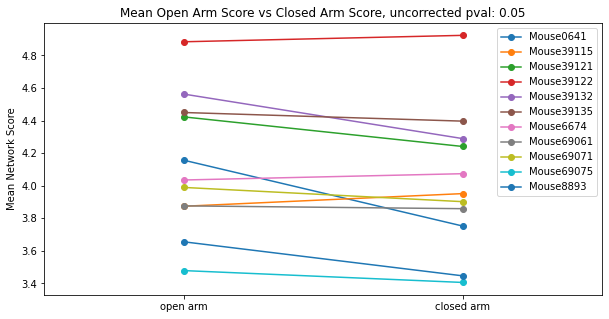

In [60]:
from scipy.stats import wilcoxon

s = model.project(X_test)
comp_s = np.sum(s[:,:3] * np.abs(model.classifier[0].weight[0].detach().cpu().numpy()),axis=1)

y_mouse = y_mouse_test
y_task = y_in_task_mask_test

mouse_list = []
open_arm_s = []
closed_arm_s = []
open_arm_t = []
closed_arm_t = []

for mouse in np.unique(y_mouse):
    mouse_mask = y_mouse==mouse
    
    mouse_obs_mask = np.logical_and(mouse_mask,test_nan_mask)
    mouse_obs_mask = np.logical_and(mouse_obs_mask,y_task==1)
    
    oa_obs_mask = np.logical_and(mouse_obs_mask,(y_test))
    ca_obs_mask = np.logical_and(mouse_obs_mask,(y_test==0))
        
    mean_oa_s = np.mean(comp_s[oa_obs_mask==1])
    mean_ca_s = np.mean(comp_s[ca_obs_mask==1])
    mean_oa_t = np.sum(oa_obs_mask)
    mean_ca_t = np.sum(ca_obs_mask)
    
    mouse_list.append(mouse)
    open_arm_s.append(mean_oa_s)
    closed_arm_s.append(mean_ca_s)
    open_arm_t.append(mean_oa_t)
    closed_arm_t.append(mean_ca_t)
    
results = wilcoxon(open_arm_s,closed_arm_s)
print("Wilcoxon Mean Open Arm Score vs Mean Closed Arm Score by Mouse: ",results.pvalue)

joined_scores = np.hstack((np.array(open_arm_s).reshape(-1,1),np.array(closed_arm_s).reshape(-1,1)))

plt.figure(figsize=(10,5))
for i, mouse in enumerate(mouse_list):
    plt.plot(joined_scores[i,:],"o-",label=mouse)
    
plt.xticks([0,1],["open arm","closed arm"])
plt.ylabel("Mean Network Score")
plt.xlim([-.5,1.5])
plt.legend()
plt.title("Mean Open Arm Score vs Closed Arm Score, uncorrected pval: {:.2f}".format(results.pvalue))
plt.savefig(FIGURE_PATH + "EPM OA vs CA Wilcox.svg")
plt.show()


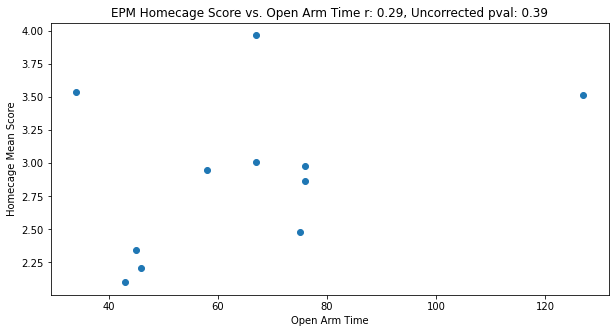

In [61]:
from scipy.stats import spearmanr

hc_mean_score = []
for i,mouse in enumerate(mouse_list):
    hc_mean_score.append(df_means[df_means["mouse"]==mouse]["composite avgHCScore"].to_numpy()[0])
    


stat,pval = spearmanr(open_arm_t,hc_mean_score)
plt.figure(figsize=(10,5))
plt.scatter(open_arm_t,hc_mean_score)
plt.xlabel("Open Arm Time")
plt.ylabel("Homecage Mean Score")
plt.title("EPM Homecage Score vs. Open Arm Time r: {:.2f}, Uncorrected pval: {:.2f}".format(stat,pval))
#plt.savefig(FIGURE_PATH + "EPM Avg Score vs OA Time Spearman.svg")
plt.show()

In [62]:
df_proj

,agg score,net 1 scores,net 2 scores,net 3 scores,in-task,mouse,time,expDate,auc (Homecage vs. Task),net 1 auc (Homecage vs. Task),net 2 auc (Homecage vs. Task),net 3 auc (Homecage vs. Task),roi,velocity
0,2.412547,0.081440,0.092658,0.096652,False,Mouse0641,1,110717,0.742232,0.718930,0.735664,0.442271,1,-2147483648
1,1.725192,0.062944,0.062938,0.081924,False,Mouse0641,2,110717,0.742232,0.718930,0.735664,0.442271,1,-2147483648
2,2.546790,0.083994,0.098514,0.112678,False,Mouse0641,4,110717,0.742232,0.718930,0.735664,0.442271,3,-2147483648
3,4.039915,0.129436,0.163424,0.065320,False,Mouse0641,12,110717,0.742232,0.718930,0.735664,0.442271,3,-2147483648
4,2.756711,0.072507,0.120995,0.040223,False,Mouse0641,13,110717,0.742232,0.718930,0.735664,0.442271,3,-2147483648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6809,2.931020,0.086615,0.123805,0.025402,True,Mouse8893,755,111017,0.659793,0.592007,0.671710,0.413127,1,0
6810,3.068778,0.081682,0.134026,0.047029,True,Mouse8893,756,111017,0.659793,0.592007,0.671710,0.413127,1,0
6811,2.202641,0.074436,0.087170,0.027823,True,Mouse8893,758,111017,0.659793,0.592007,0.671710,0.413127,1,1
6812,2.688574,0.086926,0.108569,0.037213,True,Mouse8893,759,111017,0.659793,0.592007,0.671710,0.413127,1,1


## Entry Event Plots

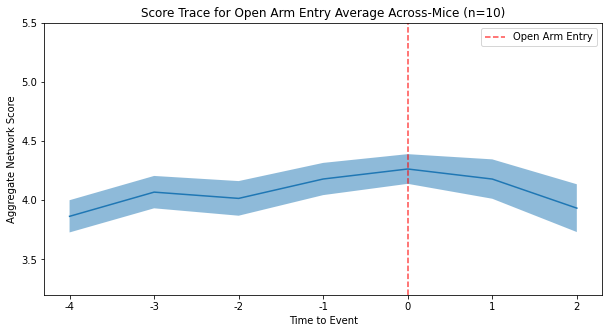

(126,)
(126, 7)


In [77]:
rois = df_proj["roi"].to_numpy()
scores = df_proj["agg score"].to_numpy()
mouse = df_proj["mouse"].to_numpy()
intask = df_proj["in-task"].to_numpy()
time = df_proj["time"].to_numpy()
roi_mask = rois > 0

five_m_in_task = np.zeros(intask.shape)

for m_id in mouse:
    mouse_mask = mouse==m_id
    
    temp_time = time[mouse_mask==1]
    temp_intask = intask[mouse_mask==1]
    
    temp_five_m = np.logical_and(np.cumsum(temp_intask) >=1, np.cumsum(temp_intask) < 300)
    
    five_m_in_task[mouse_mask==1] = temp_five_m
    
#five_m_in_task = np.logical_and(np.cumsum(intask) >= 1,np.cumsum(intask) <300)
mask = np.logical_and(roi_mask,intask)

filt_rois = 1-rois[mask==1]%2 + rois[mask==1]==5
scores_filt = scores[mask==1]
mouse_filt = mouse[mask==1]
time_filt = time[mask==1]

mouse_roi_segs = []
mouse_score_segs = []
mouse_id = []
idx_id = []
time_id = []
for mouse in np.unique(mouse_filt):
    mouse_mask = mouse_filt==mouse
    
    temp_rois = filt_rois.squeeze()[mouse_mask==1]
    temp_scores = scores_filt.squeeze()[mouse_mask==1]
    temp_time = time_filt.squeeze()[mouse_mask==1]
    
    for idx, roi in enumerate(temp_rois):
        
        if (idx > 3) and idx < (len(temp_rois) - 3):
            #print(idx)
            if temp_rois[idx]==1 and temp_rois[idx-1]==0:
                roi_seg = temp_rois[idx-4:idx+3]
                score_seg = temp_scores[idx-4:idx+3]

                mouse_roi_segs.append(np.array(roi_seg))
                mouse_score_segs.append(np.array(score_seg))
                mouse_id.append(mouse)
                idx_id.append(idx)
                time_id.append(temp_time[idx])
                
pre_zero_mask = np.sum(np.array(mouse_roi_segs)[:,:4],axis=1) == 0
post_one_mask = np.sum(np.array(mouse_roi_segs)[:,4:],axis=1) == 3
seg_mask = np.logical_and(pre_zero_mask,post_one_mask)

scores_final = np.array(mouse_score_segs)[seg_mask==1]
mouse_final = np.array(mouse_id)[seg_mask==1]
idx_final = np.array(idx_id)[seg_mask==1]
time_final = np.array(time_id)[seg_mask==1]

scores_final = np.array(mouse_score_segs)[seg_mask==1]
mouse_final = np.array(mouse_id)[seg_mask==1]

mouse_mean_scores = []

for mouse in np.unique(mouse_final):
    mouse_mask = mouse_final==mouse
    mouse_mean_scores.append(np.mean(scores_final[mouse_mask==1,:],axis=0))
    
mouse_mean_scores = np.array(mouse_mean_scores)
mean = np.mean(mouse_mean_scores,axis=0)
stderr = np.std(mouse_mean_scores,axis=0) / np.sqrt(mouse_mean_scores.shape[0])
    
plt.figure(figsize=(10,5))
plt.plot(mean)
plt.axvline(x=4,color="red",linestyle="dashed",alpha=0.7,label="Open Arm Entry")
plt.fill_between(range(7),mean+stderr,mean-stderr,alpha=0.5)
plt.ylabel("Aggregate Network Score")
plt.xlabel("Time to Event")
plt.xticks(range(7), np.arange(7) - 4)
plt.ylim([3.2,5.5])
plt.legend()
plt.title("Score Trace for Open Arm Entry Average Across-Mice (n=10)")
#plt.savefig(FIGURE_PATH + "EPM CA to OA Entry Network Trace Across-Mice.svg")
plt.show()

print(mouse_final.shape)
print(scores_final.shape)

In [78]:
CA_to_OA_data = np.hstack((mouse_final.astype(object).reshape(-1,1),scores_final.astype(object)))
df = pd.DataFrame(CA_to_OA_data)
df.columns=["Mouse","-4","-3","-2","-1","0","1","2"]
#df.to_csv(PROJECT_PATH + "EPM_Holdout_CA_to_OA_Entry.csv")
df.head()

,Mouse,-4,-3,-2,-1,0,1,2
0,Mouse0641,4.651917,4.130716,4.51992,4.446978,2.188816,6.331439,3.340452
1,Mouse0641,1.480328,5.39803,5.075718,5.727264,4.763241,6.337942,3.528203
2,Mouse0641,4.347753,4.658255,4.251202,4.26831,4.383771,4.618582,4.221119
3,Mouse0641,5.808223,3.148482,4.45965,3.184106,4.009895,5.990511,3.921562
4,Mouse0641,4.035247,3.799315,5.005692,3.244255,3.566169,4.054348,3.309307


In [79]:
CA_to_OA_data.shape

(126, 8)

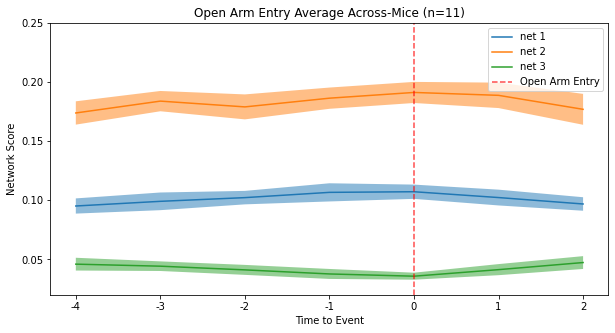

In [81]:
FIGURE_PATH = "/hpc/home/mk423/Anxiety/FullDataWork/Figures/"

rois = df_proj["roi"].to_numpy()
scores = np.hstack((df_proj["net 1 scores"].to_numpy().reshape(-1,1),
                    df_proj["net 2 scores"].to_numpy().reshape(-1,1),
                    df_proj["net 3 scores"].to_numpy().reshape(-1,1)))
mouse = df_proj["mouse"].to_numpy()
intask = df_proj["in-task"].to_numpy()
time = df_proj["time"].to_numpy()
roi_mask = rois > 0
five_m_in_task = np.zeros(intask.shape)

for m_id in mouse:
    mouse_mask = mouse==m_id
    
    temp_time = time[mouse_mask==1]
    temp_intask = intask[mouse_mask==1]
    
    temp_five_m = np.logical_and(np.cumsum(temp_intask) >=1, np.cumsum(temp_intask) < 300)
    
    five_m_in_task[mouse_mask==1] = temp_five_m
    
#five_m_in_task = np.logical_and(np.cumsum(intask) >= 1,np.cumsum(intask) <300)
mask = np.logical_and(roi_mask,intask)

filt_rois = 1-rois[mask==1]%2 + rois[mask==1]==5
scores_filt = scores[mask==1]
mouse_filt = mouse[mask==1]
time_filt = time[mask==1]

mouse_roi_segs = []
mouse_score_segs = []
mouse_id = []
idx_id = []
time_id = []
for mouse in np.unique(mouse_filt):
    mouse_mask = mouse_filt==mouse
    
    temp_rois = filt_rois.squeeze()[mouse_mask==1]
    temp_scores = scores_filt.squeeze()[mouse_mask==1]
    temp_time = time_filt.squeeze()[mouse_mask==1]
    
    for idx, roi in enumerate(temp_rois):
        
        if (idx > 3) and idx < (len(temp_rois) - 3):
            #print(idx)
            if temp_rois[idx]==1 and temp_rois[idx-1]==0:
                roi_seg = temp_rois[idx-4:idx+3]
                score_seg = temp_scores[idx-4:idx+3]

                mouse_roi_segs.append(np.array(roi_seg))
                mouse_score_segs.append(np.array(score_seg))
                mouse_id.append(mouse)
                idx_id.append(idx)
                time_id.append(temp_time[idx])
                
pre_zero_mask = np.sum(np.array(mouse_roi_segs)[:,:4],axis=1) == 0
post_one_mask = np.sum(np.array(mouse_roi_segs)[:,4:],axis=1) == 3
seg_mask = np.logical_and(pre_zero_mask,post_one_mask)
scores_final = np.array(mouse_score_segs)[seg_mask==1]
mouse_final = np.array(mouse_id)[seg_mask==1]
idx_final = np.array(idx_id)[seg_mask==1]
time_final = np.array(time_id)[seg_mask==1]



scores_final = np.array(mouse_score_segs)[seg_mask==1]
mouse_final = np.array(mouse_id)[seg_mask==1]

mouse_mean_scores = []

for mouse in np.unique(mouse_final):
    mouse_mask = mouse_final==mouse
    mouse_mean_scores.append(np.mean(scores_final[mouse_mask==1,:,:],axis=0))
    
mouse_mean_scores = np.array(mouse_mean_scores)
mean = np.mean(mouse_mean_scores,axis=0)
stderr = np.std(mouse_mean_scores,axis=0) / np.sqrt(mouse_mean_scores.shape[0])

plt.figure(figsize=(10,5))

for i in range(3):
    plt.plot(mean[:,i],label="net {}".format(i+1))
    plt.fill_between(range(7),mean[:,i]+stderr[:,i],mean[:,i]-stderr[:,i],alpha=0.5)
plt.axvline(x=4,color="red",linestyle="dashed",alpha=0.7,label="Open Arm Entry")
plt.ylim([0.02,0.25])
plt.ylabel("Network Score")
plt.xlabel("Time to Event")
plt.xticks(range(7), np.arange(7) - 4)
plt.legend()
plt.title("Open Arm Entry Average Across-Mice (n={})".format((mouse_mean_scores.shape[0])))
#plt.savefig(FIGURE_PATH + "EPM CA to OA Entry Individaul Network Trace Across-Mice.svg")
plt.show()

In [17]:
for i in range(3):
    CA_to_OA_net_data = np.hstack((mouse_final.astype(object).reshape(-1,1),scores_final[:,:,i].astype(object)))
    df = pd.DataFrame(CA_to_OA_net_data)
    df.columns=["Mouse","-4","-3","-2","-1","0","1","2"]
    df.to_csv(PROJECT_PATH + "EPM_Holdout_net_{}_CA_to_OA_Entry.csv".format(i))
    print(df.shape)
df.head()

(33, 8)
(33, 8)
(33, 8)


,Mouse,-4,-3,-2,-1,0,1,2
0,Mouse0641,0.07309,0.032816,0.022239,0.021097,0.07003,0.1196,0.063393
1,Mouse0641,0.093123,0.078859,0.000496,0.060738,0.091048,0.094783,0.112345
2,Mouse0641,0.062544,0.067643,0.055382,0.076578,0.12363,0.116217,0.052027
3,Mouse39115,0.058882,0.03938,0.083598,0.082117,0.081772,0.047814,0.104606
4,Mouse39121,0.01472,0.003884,0.059586,0.0311,0.008993,0.050538,0.008092


In [18]:
CA_to_OA_net_data.shape

(33, 8)

In [72]:
rois%2==1

array([ True,  True,  True, ...,  True,  True,  True])

(array(['Mouse0641', 'Mouse39115', 'Mouse39121', 'Mouse39122',
       'Mouse39132', 'Mouse39135', 'Mouse6674', 'Mouse69061',
       'Mouse69071', 'Mouse69075', 'Mouse8893'], dtype='<U10'), array([ 5,  8,  8,  6,  8,  7,  7, 10,  6,  8,  9]))
(10, 7)


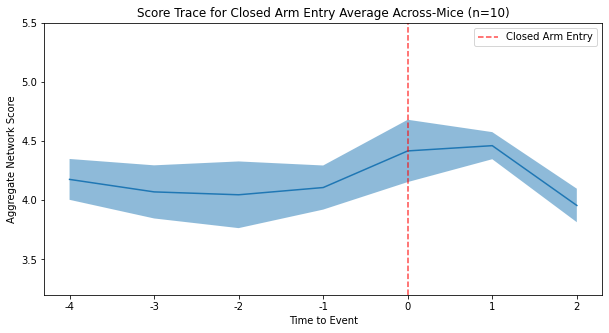

"\narray(['Mouse0641', 'Mouse39115', 'Mouse39121', 'Mouse39122',\n        'Mouse39135', 'Mouse6674', 'Mouse69061', 'Mouse69071',\n        'Mouse69075', 'Mouse8893'], dtype='<U10'),\n        "

In [82]:
rois = df_proj["roi"].to_numpy()
agg_scores = df_proj["agg score"].to_numpy()
mouse = df_proj["mouse"].to_numpy()
intask = df_proj["in-task"].to_numpy()
time = df_proj["time"].to_numpy()
roi_mask = rois > 0
five_m_in_task = np.zeros(intask.shape)

for m_id in mouse:
    mouse_mask = mouse==m_id
    
    temp_time = time[mouse_mask==1]
    temp_intask = intask[mouse_mask==1]
    
    temp_five_m = np.logical_and(np.cumsum(temp_intask) >=1, np.cumsum(temp_intask) < 300)
    
    five_m_in_task[mouse_mask==1] = temp_five_m
    
#five_m_in_task = np.logical_and(np.cumsum(intask) >= 1,np.cumsum(intask) <300)
mask = np.logical_and(roi_mask,intask)


scores = agg_scores
filt_rois = 1-rois[mask==1]%2 + rois[mask==1]==5
scores_filt = scores[mask==1]
mouse_filt = mouse[mask==1]
time_filt = time[mask==1]

mouse_roi_segs = []
mouse_score_segs = []
mouse_id = []
idx_id = []
time_id = []
for mouse in np.unique(mouse_filt):
    mouse_mask = mouse_filt==mouse
    
    temp_rois = filt_rois.squeeze()[mouse_mask==1]
    temp_scores = scores_filt.squeeze()[mouse_mask==1]
    temp_time = time_filt.squeeze()[mouse_mask==1]
    
    for idx, roi in enumerate(temp_rois):
        
        if (idx > 3) and idx < (len(temp_rois) - 3):
            #print(idx)
            if temp_rois[idx]==0 and temp_rois[idx-1]==1:
                roi_seg = temp_rois[idx-4:idx+3]
                score_seg = temp_scores[idx-4:idx+3]

                mouse_roi_segs.append(np.array(roi_seg))
                mouse_score_segs.append(np.array(score_seg))
                mouse_id.append(mouse)
                idx_id.append(idx)
                time_id.append(temp_time[idx])
                
pre_zero_mask = np.sum(np.array(mouse_roi_segs)[:,:4],axis=1) == 4
post_one_mask = np.sum(np.array(mouse_roi_segs)[:,4:],axis=1) == 0
seg_mask = np.logical_and(pre_zero_mask,post_one_mask)

scores_final = np.array(mouse_score_segs)[seg_mask==1]
mouse_final = np.array(mouse_id)[seg_mask==1]
idx_final = np.array(idx_id)[seg_mask==1]
time_final = np.array(time_id)[seg_mask==1]

scores_final = np.array(mouse_score_segs)[seg_mask==1]
mouse_final = np.array(mouse_id)[seg_mask==1]

mouse_mean_scores = []

for mouse in np.unique(mouse_final):
    if mouse=="Mouse39132":
        continue
    else:
        mouse_mask = mouse_final==mouse
        mouse_mean_scores.append(np.mean(scores_final[mouse_mask==1,:],axis=0))
    
mouse_mean_scores = np.array(mouse_mean_scores)
mean = np.mean(mouse_mean_scores,axis=0)
stderr = np.std(mouse_mean_scores,axis=0) / np.sqrt(mouse_mean_scores.shape[0])
print(np.unique(mouse_final,return_counts=True))
print(mouse_mean_scores.shape)
plt.figure(figsize=(10,5))
plt.plot(mean)
plt.axvline(x=4,color="red",linestyle="dashed",alpha=0.7,label="Closed Arm Entry")
plt.fill_between(range(7),mean+stderr,mean-stderr,alpha=0.5)
plt.ylabel("Aggregate Network Score")
plt.xlabel("Time to Event")
plt.xticks(range(7), np.arange(7) - 4)
plt.ylim([3.2,5.5])
plt.legend()
plt.title("Score Trace for Closed Arm Entry Average Across-Mice (n={})".format(mouse_mean_scores.shape[0]))
#plt.savefig(FIGURE_PATH + "EPM OA to CA Entry Network Trace Across-Mice.svg")
plt.show()

"""
array(['Mouse0641', 'Mouse39115', 'Mouse39121', 'Mouse39122',
        'Mouse39135', 'Mouse6674', 'Mouse69061', 'Mouse69071',
        'Mouse69075', 'Mouse8893'], dtype='<U10'),
        """

In [74]:
scores_final

array([[2.4990625 , 3.9104288 , 4.516836  , 3.850727  , 4.0596123 ,
        3.9107335 , 3.5304956 ],
       [5.064001  , 5.6969986 , 4.33609   , 3.8448892 , 5.145536  ,
        3.8232408 , 2.5812163 ],
       [5.9868774 , 1.92689   , 4.2996616 , 2.7292855 , 4.3255343 ,
        4.21555   , 3.0718193 ],
       [5.7861032 , 3.473048  , 5.4929433 , 4.67606   , 6.7645364 ,
        3.658906  , 5.4793277 ],
       [4.5018864 , 5.6327243 , 3.2225866 , 2.0213604 , 4.4343266 ,
        4.576859  , 4.2524185 ],
       [6.175003  , 5.644164  , 5.3390737 , 7.136852  , 3.3616686 ,
        3.5412254 , 2.7099314 ],
       [4.8340735 , 3.9479086 , 5.769486  , 2.921121  , 7.5274987 ,
        4.277991  , 2.0547292 ],
       [5.1803484 , 5.6668887 , 5.846495  , 8.125349  , 6.964073  ,
        6.4893265 , 5.3381305 ],
       [3.760875  , 4.4492598 , 5.650184  , 4.5817094 , 4.4709373 ,
        6.449226  , 4.7011156 ],
       [4.3455024 , 5.2563543 , 4.512846  , 6.789912  , 7.29392   ,
        4.661319  , 4.9

In [21]:
np.unique(mouse_final,return_counts=True)

(array(['Mouse0641', 'Mouse39115', 'Mouse39121', 'Mouse39122',
        'Mouse39132', 'Mouse39135', 'Mouse6674', 'Mouse69061',
        'Mouse69071', 'Mouse69075', 'Mouse8893'], dtype='<U10'),
 array([3, 3, 2, 4, 1, 2, 8, 4, 1, 2, 2]))

In [22]:
np.unique(mouse_final,return_counts=True)

(array(['Mouse0641', 'Mouse39115', 'Mouse39121', 'Mouse39122',
        'Mouse39132', 'Mouse39135', 'Mouse6674', 'Mouse69061',
        'Mouse69071', 'Mouse69075', 'Mouse8893'], dtype='<U10'),
 array([3, 3, 2, 4, 1, 2, 8, 4, 1, 2, 2]))

In [23]:
OA_to_CA_data = np.hstack((mouse_final.astype(object).reshape(-1,1),scores_final.astype(object)))
df = pd.DataFrame(OA_to_CA_data)
df.columns=["Mouse","-4","-3","-2","-1","0","1","2"]
df.to_csv(PROJECT_PATH + "EPM_Holdout_OA_to_CA_Entry.csv")
print(df.shape)
df.head()

(32, 8)


,Mouse,-4,-3,-2,-1,0,1,2
0,Mouse0641,4.620972,4.143009,5.322319,2.591476,3.213095,2.844295,4.353071
1,Mouse0641,3.815422,4.362512,4.253851,3.386782,4.717763,4.151978,4.09345
2,Mouse0641,4.814712,3.810013,6.375933,5.506393,5.153796,5.009541,2.600715
3,Mouse39115,3.205511,4.457887,3.754186,3.330766,5.786103,3.473048,5.492943
4,Mouse39115,3.660758,3.912433,4.344426,3.09443,3.770207,4.686513,1.741025


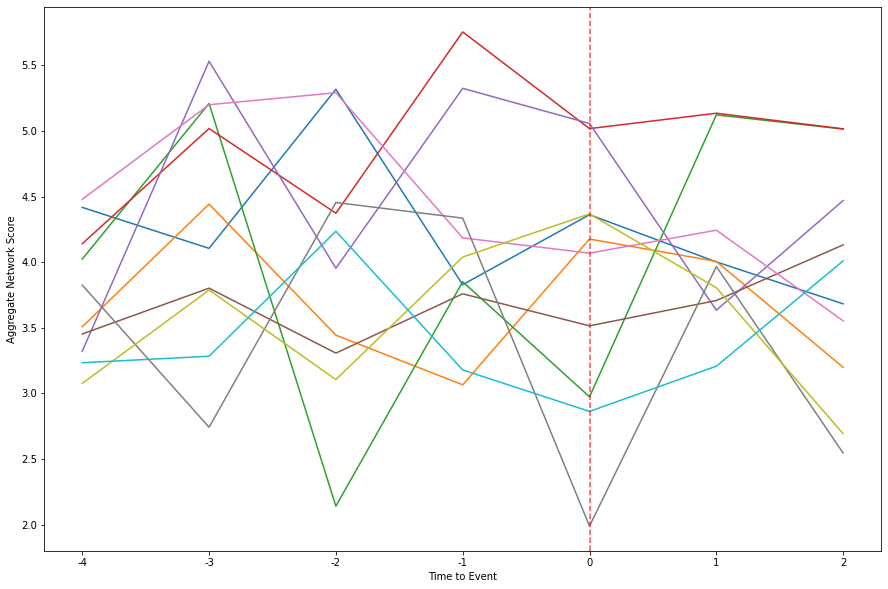

In [24]:
plt.figure(figsize=(15,10))
for mouse in mouse_mean_scores:
    plt.plot(range(7),mouse)
    

plt.ylabel("Aggregate Network Score")
plt.xlabel("Time to Event")
plt.axvline(x=4,color="red",linestyle="dashed",alpha=0.7,label="Closed Arm Entry")
plt.xticks(range(7), np.arange(7) - 4)
plt.show()

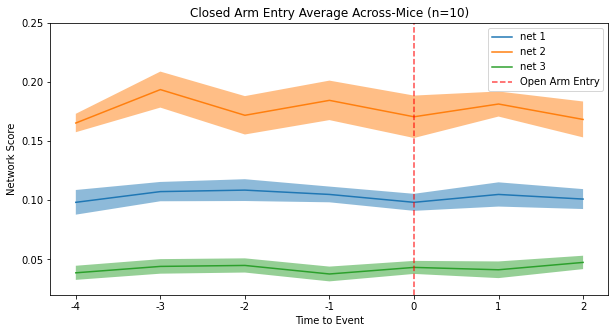

In [25]:
FIGURE_PATH = "/hpc/home/mk423/Anxiety/FullDataWork/Figures/"

rois = df_proj["roi"].to_numpy()
scores = np.hstack((df_proj["net 1 scores"].to_numpy().reshape(-1,1),
                    df_proj["net 2 scores"].to_numpy().reshape(-1,1),
                    df_proj["net 3 scores"].to_numpy().reshape(-1,1)))
mouse = df_proj["mouse"].to_numpy()
intask = df_proj["in-task"].to_numpy()
time = df_proj["time"].to_numpy()
roi_mask = rois > 0
five_m_in_task = np.zeros(intask.shape)

for m_id in mouse:
    mouse_mask = mouse==m_id
    
    temp_time = time[mouse_mask==1]
    temp_intask = intask[mouse_mask==1]
    
    temp_five_m = np.logical_and(np.cumsum(temp_intask) >=1, np.cumsum(temp_intask) < 300)
    
    five_m_in_task[mouse_mask==1] = temp_five_m
    
#five_m_in_task = np.logical_and(np.cumsum(intask) >= 1,np.cumsum(intask) <300)
mask = np.logical_and(roi_mask,intask)

filt_rois = rois[mask==1]%2
scores_filt = scores[mask==1]
mouse_filt = mouse[mask==1]
time_filt = time[mask==1]

mouse_roi_segs = []
mouse_score_segs = []
mouse_id = []
idx_id = []
time_id = []

for mouse in np.unique(mouse_filt):
    mouse_mask = mouse_filt==mouse
    
    temp_rois = filt_rois.squeeze()[mouse_mask==1]
    temp_scores = scores_filt.squeeze()[mouse_mask==1]
    temp_time = time_filt.squeeze()[mouse_mask==1]
    
    for idx, roi in enumerate(temp_rois):
        
        if (idx > 3) and idx < (len(temp_rois) - 3):
            #print(idx)
            if temp_rois[idx]==0 and temp_rois[idx-1]==1:
                roi_seg = temp_rois[idx-4:idx+3]
                score_seg = temp_scores[idx-4:idx+3]

                mouse_roi_segs.append(np.array(roi_seg))
                mouse_score_segs.append(np.array(score_seg))
                mouse_id.append(mouse)
                idx_id.append(idx)
                time_id.append(temp_time[idx])
                
pre_zero_mask = np.sum(np.array(mouse_roi_segs)[:,:4],axis=1) == 4
post_one_mask = np.sum(np.array(mouse_roi_segs)[:,4:],axis=1) == 0
seg_mask = np.logical_and(pre_zero_mask,post_one_mask)
scores_final = np.array(mouse_score_segs)[seg_mask==1]
mouse_final = np.array(mouse_id)[seg_mask==1]
idx_final = np.array(idx_id)[seg_mask==1]
time_final = np.array(time_id)[seg_mask==1]



scores_final = np.array(mouse_score_segs)[seg_mask==1]
mouse_final = np.array(mouse_id)[seg_mask==1]

mouse_mean_scores = []

for mouse in np.unique(mouse_final):
    if mouse=="Mouse39132":
        continue
    else:
        mouse_mask = mouse_final==mouse
        mouse_mean_scores.append(np.mean(scores_final[mouse_mask==1,:,:],axis=0))
    
mouse_mean_scores = np.array(mouse_mean_scores)
mean = np.mean(mouse_mean_scores,axis=0)
stderr = np.std(mouse_mean_scores,axis=0) / np.sqrt(mouse_mean_scores.shape[0])

plt.figure(figsize=(10,5))

for i in range(3):
    plt.plot(mean[:,i],label="net {}".format(i+1))
    plt.fill_between(range(7),mean[:,i]+stderr[:,i],mean[:,i]-stderr[:,i],alpha=0.5)
plt.axvline(x=4,color="red",linestyle="dashed",alpha=0.7,label="Open Arm Entry")
plt.ylabel("Network Score")
plt.xlabel("Time to Event")
plt.ylim([0.02,0.25])
plt.xticks(range(7), np.arange(7) - 4)
plt.legend()
plt.title("Closed Arm Entry Average Across-Mice (n={})".format((mouse_mean_scores.shape[0])))
plt.savefig(FIGURE_PATH + "EPM OA to CA Entry Individual Network Trace Across-Mice.svg")
plt.show()

In [26]:
mouse_final

array(['Mouse0641', 'Mouse0641', 'Mouse0641', 'Mouse39115', 'Mouse39115',
       'Mouse39115', 'Mouse39121', 'Mouse39121', 'Mouse39122',
       'Mouse39122', 'Mouse39122', 'Mouse39122', 'Mouse39132',
       'Mouse39135', 'Mouse39135', 'Mouse6674', 'Mouse6674', 'Mouse6674',
       'Mouse6674', 'Mouse6674', 'Mouse6674', 'Mouse6674', 'Mouse6674',
       'Mouse69061', 'Mouse69061', 'Mouse69061', 'Mouse69061',
       'Mouse69071', 'Mouse69075', 'Mouse69075', 'Mouse8893', 'Mouse8893'],
      dtype='<U10')

In [27]:
for i in range(3):
    OA_to_CA_net_data = np.hstack((mouse_final.astype(object).reshape(-1,1),scores_final[:,:,i].astype(object)))
    df = pd.DataFrame(OA_to_CA_net_data)
    df.columns=["Mouse","-4","-3","-2","-1","0","1","2"]
    df.to_csv(PROJECT_PATH + "EPM_Holdout_net_{}_OA_to_CA_Entry.csv".format(i))
    print(df.shape)
df.head()

(32, 8)
(32, 8)
(32, 8)


,Mouse,-4,-3,-2,-1,0,1,2
0,Mouse0641,0.012568,0.046017,0.08306,0.019409,0.103332,0.092508,0.024812
1,Mouse0641,0.11329,0.109067,0.086173,0.037135,0.054856,0.081273,0.046472
2,Mouse0641,0.077172,0.092158,0.036744,0.069754,0.048065,0.02978,0.111082
3,Mouse39115,0.027314,0.062435,0.057232,0.082587,0.058882,0.03938,0.083598
4,Mouse39115,0.039821,0.033097,0.037671,0.050871,0.07906,0.008076,0.067093


In [28]:
time_points_dict = {}
for mouse in np.unique(mouse_final):
    time_points_dict[mouse] = []
    
for i, mouse in enumerate(mouse_final):
    
    for j in np.unique(mouse_final):
        if j==mouse:
            time_points_dict[mouse].append(time_final[i])
        else:
            time_points_dict[j].append(np.nan)
            


In [29]:
df = pd.DataFrame.from_dict(time_points_dict)
df.to_csv(PROJECT_PATH + "EPM_CA_to_OA_timepoints.csv")

In [30]:
df

,Mouse0641,Mouse39115,Mouse39121,Mouse39122,Mouse39132,Mouse39135,Mouse6674,Mouse69061,Mouse69071,Mouse69075,Mouse8893
0,442.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,508.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,613.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,447.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,587.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,438.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,660.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,328.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,389.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
df_proj[["mouse","expDate"]]

,mouse,expDate
0,Mouse0641,110717
1,Mouse0641,110717
2,Mouse0641,110717
3,Mouse0641,110717
4,Mouse0641,110717
...,...,...
6809,Mouse8893,111017
6810,Mouse8893,111017
6811,Mouse8893,111017
6812,Mouse8893,111017


In [42]:
for mouse in np.unique(df_proj["mouse"]):
    print(mouse,np.unique(df_proj[df_proj["mouse"]==mouse]["expDate"]))

Mouse0641 ['110717']
Mouse39115 ['091921']
Mouse39121 ['091921']
Mouse39122 ['091921']
Mouse39132 ['091921']
Mouse39135 ['091921']
Mouse6674 ['051118']
Mouse69061 ['100621']
Mouse69071 ['100621']
Mouse69075 ['100621']
Mouse8893 ['111017']


In [47]:
task_mask = df_proj["in-task"]==1
for mouse in np.unique(df_proj.mouse):
    df_mouse = df_proj[np.logical_and(df_proj.mouse==mouse,task_mask)==1]
    print(len(np.where(df_mouse["roi"]%2==1)[0]),len(np.where(df_mouse["roi"]%2==0)[0]))


206 58
300 43
299 47
260 68
256 34
247 75
457 163
296 69
268 78
269 47
510 76


In [42]:
np.where(df_mouse["roi"]%2==0)

(array([  2,  11,  13,  14,  22,  23,  50,  58,  75,  81, 109, 117, 118,
        119, 120, 121, 122, 123, 124, 125, 126, 135, 136, 137, 138, 139,
        140, 141, 142, 143, 157, 168, 169, 183, 196, 197, 198, 199, 200,
        201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213,
        214, 215, 216, 217, 218, 222]),)

In [31]:
df_mouse["time"].values[0]

147

In [18]:
df_proj

,agg score,net 1 scores,net 2 scores,net 3 scores,in-task,mouse,time,expDate,auc (Homecage vs. Task),net 1 auc (Homecage vs. Task),net 2 auc (Homecage vs. Task),net 3 auc (Homecage vs. Task),roi,velocity
0,2.412547,0.081440,0.092658,0.096652,False,Mouse0641,1,110717,0.742232,0.718930,0.735664,0.442271,1,-2147483648
1,1.725192,0.062944,0.062938,0.081924,False,Mouse0641,2,110717,0.742232,0.718930,0.735664,0.442271,1,-2147483648
2,2.546790,0.083994,0.098514,0.112678,False,Mouse0641,4,110717,0.742232,0.718930,0.735664,0.442271,3,-2147483648
3,4.039915,0.129436,0.163424,0.065320,False,Mouse0641,12,110717,0.742232,0.718930,0.735664,0.442271,3,-2147483648
4,2.756711,0.072507,0.120995,0.040223,False,Mouse0641,13,110717,0.742232,0.718930,0.735664,0.442271,3,-2147483648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6809,2.931020,0.086615,0.123805,0.025402,True,Mouse8893,755,111017,0.659793,0.592007,0.671710,0.413127,1,0
6810,3.068778,0.081682,0.134026,0.047029,True,Mouse8893,756,111017,0.659793,0.592007,0.671710,0.413127,1,0
6811,2.202641,0.074436,0.087170,0.027823,True,Mouse8893,758,111017,0.659793,0.592007,0.671710,0.413127,1,1
6812,2.688574,0.086926,0.108569,0.037213,True,Mouse8893,759,111017,0.659793,0.592007,0.671710,0.413127,1,1


In [38]:
np.unique(df_proj["roi"]%2)

array([0, 1], dtype=int32)

(32,)
(32, 7)
(array(['Mouse0641', 'Mouse39115', 'Mouse39121', 'Mouse39122',
       'Mouse39135', 'Mouse6674', 'Mouse69061', 'Mouse69071',
       'Mouse69075', 'Mouse8893'], dtype='<U10'), array([3, 1, 1, 7, 2, 7, 5, 2, 3, 2]))
(10, 7)


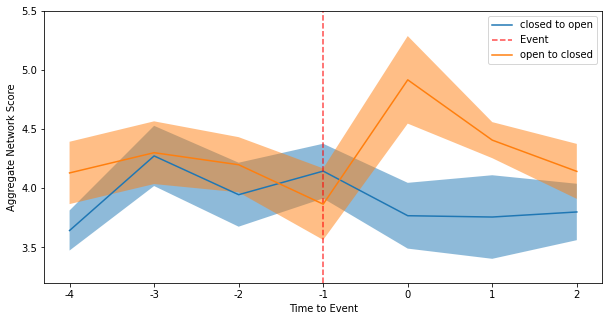

In [91]:
rois = df_proj["roi"].to_numpy()
scores = df_proj["agg score"].to_numpy()
mouse = df_proj["mouse"].to_numpy()
intask = df_proj["in-task"].to_numpy()
time = df_proj["time"].to_numpy()
roi_mask = rois > 0

five_m_in_task = np.zeros(intask.shape)

for m_id in mouse:
    mouse_mask = mouse==m_id
    
    temp_time = time[mouse_mask==1]
    temp_intask = intask[mouse_mask==1]
    
    temp_five_m = np.logical_and(np.cumsum(temp_intask) >=1, np.cumsum(temp_intask) < 300)
    
    five_m_in_task[mouse_mask==1] = temp_five_m
    
#five_m_in_task = np.logical_and(np.cumsum(intask) >= 1,np.cumsum(intask) <300)
mask = np.logical_and(roi_mask,intask)

filt_rois = 1-rois[mask==1]%2 #+ rois[mask==1]==5
scores_filt = scores[mask==1]
mouse_filt = mouse[mask==1]
time_filt = time[mask==1]

mouse_roi_segs = []
mouse_score_segs = []
mouse_id = []
idx_id = []
time_id = []
for mouse in np.unique(mouse_filt):
    mouse_mask = mouse_filt==mouse
    
    temp_rois = filt_rois.squeeze()[mouse_mask==1]
    temp_scores = scores_filt.squeeze()[mouse_mask==1]
    temp_time = time_filt.squeeze()[mouse_mask==1]
    
    for idx, roi in enumerate(temp_rois):
        
        if (idx > 3) and idx < (len(temp_rois) - 3):
            #print(idx)
            if temp_rois[idx]==1 and temp_rois[idx-1]==0:
                roi_seg = temp_rois[idx-4:idx+3]
                score_seg = temp_scores[idx-4:idx+3]

                mouse_roi_segs.append(np.array(roi_seg))
                mouse_score_segs.append(np.array(score_seg))
                mouse_id.append(mouse)
                idx_id.append(idx)
                time_id.append(temp_time[idx])
                
pre_zero_mask = np.sum(np.array(mouse_roi_segs)[:,:4],axis=1) == 0
post_one_mask = np.sum(np.array(mouse_roi_segs)[:,4:],axis=1) == 3
seg_mask = np.logical_and(pre_zero_mask,post_one_mask)

scores_final = np.array(mouse_score_segs)[seg_mask==1]
mouse_final = np.array(mouse_id)[seg_mask==1]
idx_final = np.array(idx_id)[seg_mask==1]
time_final = np.array(time_id)[seg_mask==1]

scores_final = np.array(mouse_score_segs)[seg_mask==1]
mouse_final = np.array(mouse_id)[seg_mask==1]

mouse_mean_scores = []

for mouse in np.unique(mouse_final):
    mouse_mask = mouse_final==mouse
    mouse_mean_scores.append(np.mean(scores_final[mouse_mask==1,:],axis=0))
    
mouse_mean_scores = np.array(mouse_mean_scores)
mean = np.mean(mouse_mean_scores,axis=0)
stderr = np.std(mouse_mean_scores,axis=0) / np.sqrt(mouse_mean_scores.shape[0])
    
plt.figure(figsize=(10,5))
plt.plot(mean,label="closed to open")
plt.axvline(x=3,color="red",linestyle="dashed",alpha=0.7,label="Event")
plt.fill_between(range(7),mean+stderr,mean-stderr,alpha=0.5)
#plt.savefig(FIGURE_PATH + "EPM CA to OA Entry Network Trace Across-Mice.svg")
#plt.show()

print(mouse_final.shape)
print(scores_final.shape)

rois = df_proj["roi"].to_numpy()
agg_scores = df_proj["agg score"].to_numpy()
mouse = df_proj["mouse"].to_numpy()
intask = df_proj["in-task"].to_numpy()
time = df_proj["time"].to_numpy()
roi_mask = rois > 0
five_m_in_task = np.zeros(intask.shape)

for m_id in mouse:
    mouse_mask = mouse==m_id
    
    temp_time = time[mouse_mask==1]
    temp_intask = intask[mouse_mask==1]
    
    temp_five_m = np.logical_and(np.cumsum(temp_intask) >=1, np.cumsum(temp_intask) < 300)
    
    five_m_in_task[mouse_mask==1] = temp_five_m
    
#five_m_in_task = np.logical_and(np.cumsum(intask) >= 1,np.cumsum(intask) <300)
mask = np.logical_and(roi_mask,intask)


scores = agg_scores
filt_rois = 1-rois[mask==1]%2 #+ rois[mask==1]==5
scores_filt = scores[mask==1]
mouse_filt = mouse[mask==1]
time_filt = time[mask==1]

mouse_roi_segs = []
mouse_score_segs = []
mouse_id = []
idx_id = []
time_id = []
for mouse in np.unique(mouse_filt):
    mouse_mask = mouse_filt==mouse
    
    temp_rois = filt_rois.squeeze()[mouse_mask==1]
    temp_scores = scores_filt.squeeze()[mouse_mask==1]
    temp_time = time_filt.squeeze()[mouse_mask==1]
    
    for idx, roi in enumerate(temp_rois):
        
        if (idx > 3) and idx < (len(temp_rois) - 3):
            #print(idx)
            if temp_rois[idx]==0 and temp_rois[idx-1]==1:
                roi_seg = temp_rois[idx-4:idx+3]
                score_seg = temp_scores[idx-4:idx+3]

                mouse_roi_segs.append(np.array(roi_seg))
                mouse_score_segs.append(np.array(score_seg))
                mouse_id.append(mouse)
                idx_id.append(idx)
                time_id.append(temp_time[idx])
                
pre_zero_mask = np.sum(np.array(mouse_roi_segs)[:,:4],axis=1) == 4
post_one_mask = np.sum(np.array(mouse_roi_segs)[:,4:],axis=1) == 0
seg_mask = np.logical_and(pre_zero_mask,post_one_mask)

scores_final = np.array(mouse_score_segs)[seg_mask==1]
mouse_final = np.array(mouse_id)[seg_mask==1]
idx_final = np.array(idx_id)[seg_mask==1]
time_final = np.array(time_id)[seg_mask==1]

scores_final = np.array(mouse_score_segs)[seg_mask==1]
mouse_final = np.array(mouse_id)[seg_mask==1]

mouse_mean_scores = []

for mouse in np.unique(mouse_final):
    if mouse=="Mouse39132":
        continue
    else:
        mouse_mask = mouse_final==mouse
        mouse_mean_scores.append(np.mean(scores_final[mouse_mask==1,:],axis=0))
    
mouse_mean_scores = np.array(mouse_mean_scores)
mean = np.mean(mouse_mean_scores,axis=0)
stderr = np.std(mouse_mean_scores,axis=0) / np.sqrt(mouse_mean_scores.shape[0])
print(np.unique(mouse_final,return_counts=True))
print(mouse_mean_scores.shape)
#plt.figure(figsize=(10,5))
plt.plot(mean,label="open to closed")
#plt.axvline(x=4,color="red",linestyle="dashed",alpha=0.7,label="Event")
plt.fill_between(range(7),mean+stderr,mean-stderr,alpha=0.5)
plt.ylabel("Aggregate Network Score")
plt.xlabel("Time to Event")
plt.xticks(range(7), np.arange(7) - 4)
plt.ylim([3.2,5.5])
plt.legend()
#plt.title("Score Trace for Closed Arm Entry Average Across-Mice (n={})".format(mouse_mean_scores.shape[0]))
#plt.savefig(FIGURE_PATH + "EPM OA to CA Entry Network Trace Across-Mice.svg")
plt.show()

## Null Distribution Test

In [12]:
'''with open(data_file,"rb") as f:
    epm_test_dict = pickle.load(f)

X_test = np.hstack([epm_test_dict[feature]*weight for feature,weight in zip(old_feature_list,feature_weights)])
y_test = ~(epm_test_dict['y_ROI']%2).astype(bool)
y_in_task_mask_test= ~epm_test_dict['y_Homecage'].astype(bool)
y_mouse_test = epm_test_dict['y_mouse']
y_time_test = epm_test_dict['y_time']
test_nan_mask = (epm_test_dict['y_ROI'] > 0)
epm_y_expDate_test = epm_test_dict['y_expDate']'''

mouse_mask = np.array(y_mouse_test)==y_mouse_test[0]

X_temp = X_test[mouse_mask==1]
y_intask = y_in_task_mask_test[mouse_mask==1]
y_pred_temp = model.predict_proba(X_temp).squeeze()

(array([   8.,   59.,  399., 1406., 2666., 3046., 1745.,  559.,  103.,
           9.]),
 array([0.34987534, 0.37919064, 0.40850595, 0.43782125, 0.46713656,
        0.49645186, 0.52576717, 0.55508247, 0.58439778, 0.61371308,
        0.64302839]),
 <BarContainer object of 10 artists>)

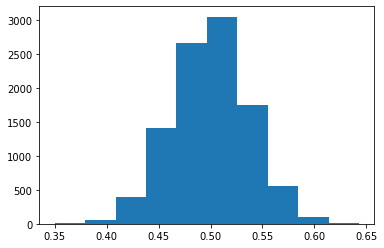

In [20]:
from sklearn.metrics import roc_auc_score
shuffle_labels = y_intask.copy()
auc_list = []
for i in range(10000):
    np.random.shuffle(shuffle_labels)
    auc_list.append(roc_auc_score(shuffle_labels,
                                  y_pred_temp))
    
plt.hist(auc_list)

In [14]:
np.random.shuffle(y_intask)